In [1]:
# fig, ax = plt.subplots()
# #fig.set_size_inches(20,10)
# ax.set_aspect('equal')
# grid = np.zeros(map_size)
# grid[10:30, 30:60] = 1
# plt.imshow(grid, cmap = 'gray')
# plt.show()
# # ax.plot(error_x, label='pose_error_x', color='blue')
# # ax.set_title('pose_error_x')

In [2]:
"""

Using given scans and poses build plot with the occupancy grid and robot trajectory

convert sensor readings from polar coordinates to Cartesian
use func convert2xy

shift all measurments so no negative left

Create grid filled with zeros

convert from robot frame to world frame
first pose is an orientation of the map

For each measurement and pose:
    Convert points to Cartesian coordinates in the global reference frame
    Create probabilities occupancy grid for the measurement
    Convert probabilities to log-odds representation and add them to the grid

Convert grid from log-odds representation to probabilities Plot occupancy grid and robot trajectory



FIXME: check direction of rotation
"""

'\n\nUsing given scans and poses build plot with the occupancy grid and robot trajectory\n\nconvert sensor readings from polar coordinates to Cartesian\nuse func convert2xy\n\nshift all measurments so no negative left\n\nCreate grid filled with zeros\n\nconvert from robot frame to world frame\nfirst pose is an orientation of the map\n\nFor each measurement and pose:\n    Convert points to Cartesian coordinates in the global reference frame\n    Create probabilities occupancy grid for the measurement\n    Convert probabilities to log-odds representation and add them to the grid\n\nConvert grid from log-odds representation to probabilities Plot occupancy grid and robot trajectory\n\n\n\nFIXME: check direction of rotation\n'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tools import convert2xy
from tools import convert2map
from tqdm import tqdm

from PIL import Image, ImageDraw

In [4]:
# used functions

def rotate(points, angle):
    s, c = np.sin(angle), np.cos(angle)
    r = np.array([[c, s], [-s, c]])
    return np.dot(points[:, :2], r)
# poses_[:, :2] = np.dot(poses_[:, :2], r)


def convert2xy(scan, fov=260, min_dist=0.02):
    """Converts scan data to list of XY points descarding values with distances
    less than `min_dist`.

    Parameters
    ----------
    scan : array-like
        List of scan measurments in mm
    fov : scalar, optional
        Field Of View of the sensor in degrees
    min_dist : scalar, optional
        Minimal distance of measurment in mm for filtering out values

    Returns
    -------
    points : ndarray
        List of XY points
    """
    angles = np.radians(np.linspace(-fov/2, fov/2, len(scan)))
    points = np.vstack([scan*np.cos(angles), scan*np.sin(angles)]).T
    return points[scan>min_dist]

def convert2map(pose, points, map_pix, map_size, prob):
    """Converts list of XY points to 2D array map in which each pixel denotes
    probability of pixel being occupied.

    Parameters
    ----------
    pose : ndarray
        XY coordinates of the robot in the map reference frame
    points : ndarray
        List of XY points measured by sensor in the map reference frame
    map_pix : int
        Size of map pixel in m
    map_size : tuple
        Size of the map in pixels
    prob : float
        Probability


    Returns
    -------
    map : ndarray
        2D array representing map with dtype numpy.float32
    """
    zero = (pose//map_pix).astype(np.int32)
    pixels = (points//map_pix).astype(np.int32)
    mask = (pixels[:, 0] >= 0) & (pixels[:, 0] < map_size[0]) & \
           (pixels[:, 1] >= 0) & (pixels[:, 1] < map_size[1])
    pixels = pixels[mask]
    img = Image.new('L', (map_size[1], map_size[0]))
    draw = ImageDraw.Draw(img)
    zero = (zero[1], zero[0])
    for p in set([(q[1], q[0]) for q in pixels]):
        draw.line([zero, p], fill=1)
    data = -np.fromstring(img.tobytes(), np.int8).reshape(map_size)
    data[pixels[:, 0], pixels[:, 1]] = 1
    return 0.5 + prob*data.astype(np.float32)


In [5]:
poses = np.load('poses.npy')
scans = np.load('scans.npy')

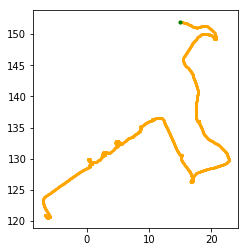

In [6]:
# plot raw poses

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(poses[:, 0], poses[:, 1], s = 1, c = 'orange')
ax.scatter(poses[0, 0], poses[0, 1], s = 10, c = 'green')  # starting point
plt.show()

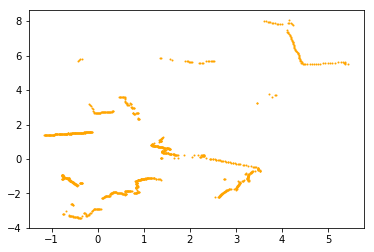

In [9]:
# plot one raw scan in Robot Frame

fig, ax = plt.subplots()
scan = scans[0]  # first in polar coords
scan_xy_robot_frame = convert2xy(scan)  # transform to XY coords
ax.scatter(scan_xy_robot_frame[:, 0], scan_xy_robot_frame[:, 1], s = 1, c = 'orange')

plt.show()

pose angle
-1.33691


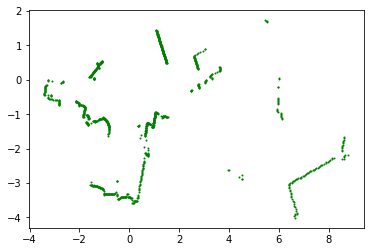

In [10]:
# rotate scan to World Frame (according to pose it was made from)

fig, ax = plt.subplots()

pose = poses[0]
print("pose angle")
print(pose[2])
scan_xy_global = rotate(scan_xy_robot_frame, pose[2])
ax.scatter(scan_xy_global[:, 0], scan_xy_global[:, 1], s = 1, c = 'green')
plt.show()

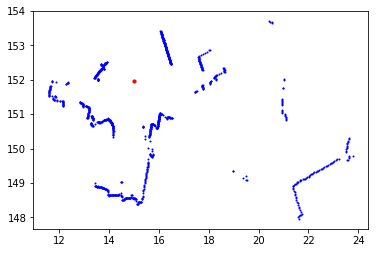

In [11]:
#  move scan to pose it was made from

fig, ax = plt.subplots()
ax.scatter(scan_xy_global[:, 0] + pose[0], scan_xy_global[:, 1] + pose[1], s = 1, c = 'blue')
ax.scatter(pose[0], pose[1], s = 10, c = 'red')

plt.show()

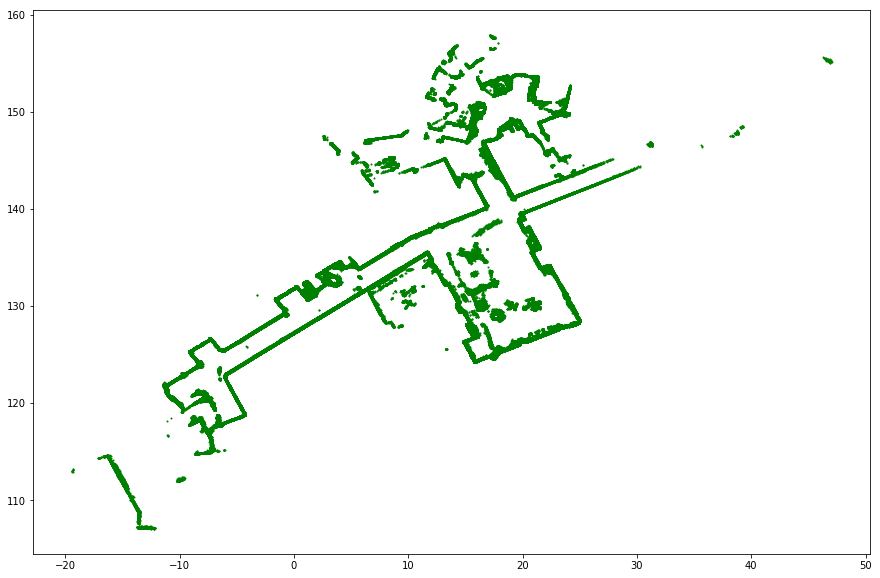

In [15]:
# plot all scans according to poses they were made from
"""
poses (5000, 3)
scan_xy_global (1032, 2) ... (1029, 2) - can be different
"""

fig = plt.figure(figsize=(15,10))

for i, pose in enumerate(poses):
    scan_xy_robot_frame = convert2xy(scans[i])  # from local polar to local XY
    scan_xy_global = rotate(scan_xy_robot_frame, pose[2])
    scan_xy_global += pose[:2]
    plt.scatter(scan_xy_global[:, 0], scan_xy_global[:, 1],  s = 1, c = 'green')
plt.show()

Make log-odds representation:
- l = log(p/(1-p))
- p = 1/(1+exp(-l))
- li+1= log(pi/(1-pi)) + li , here pi – is probability for the cell given by i-th measurement


    """
    scans have different shape, so normally we can't concatenate them
    need to do real-time system
    
    Input: solo scan, solo pose, map size
    
    Inside:
        convert measurments from polar coords to xy coords: scan_xy_robot_frame
        transform from robot frame to world frame: scan_xy_world_frame
        convert scan to probabilistic representation: scan_to_map
        convert probabilistic map to log-odds representation: l = log(p/(1-p))

    Output: log-odds representation of this particular scan on a map
    
    """

0it [00:00, ?it/s]/Users/nickzherdev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
5000it [00:42, 119.03it/s]


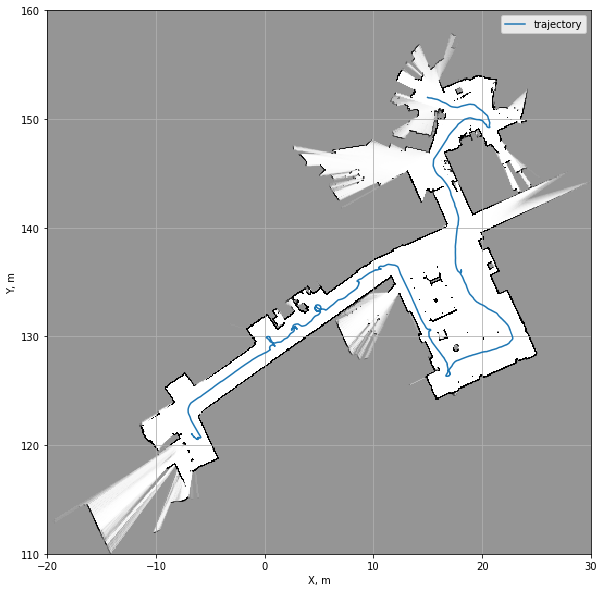

In [22]:
map_size = (500, 500)
map_pix = 0.1
sdvig = np.array([20, -110, 0])

fig = plt.figure(figsize=(10,10))

poses_normed = poses + sdvig
map_ = np.zeros(map_size)

for pose, scan in tqdm(zip(poses_normed, scans)):
    points = rotate(convert2xy(scan), pose[2]) + pose[:2]
    scan_to_map = convert2map(pose[:2], points, map_pix, map_size, 0.01)
    map_ += np.log(scan_to_map/(np.ones(map_size)-scan_to_map))

# convert log odds back to prob
map_ = 1 / (np.ones(map_size) + np.exp(-map_))

extent = [
    -sdvig[0], map_size[0]*map_pix-sdvig[0],
    -sdvig[1], map_size[1]*map_pix-sdvig[1],
]
plt.imshow(map_.T[::-1], vmin=0, vmax=1, cmap=plt.cm.Greys, extent=extent)
plt.plot(poses[:, 0], poses[:, 1], label="trajectory")
plt.xlabel("X, m")
plt.ylabel("Y, m")
plt.legend(loc=1)
plt.grid()
plt.show()


# for pose, scan in zip(poses[:100] + delta, scans[:100]):
#     scan_xy_robot_frame = convert2xy(scans[i])  # from local polar to local XY
#     scan_xy_global = rotate(scan_xy_robot_frame, pose[2]) + pose[:2]
#     scan_to_map = convert2map(pose[:2], scan_xy_global, map_pix = 0.1, map_size = map_size, prob = 0.3)
#     map_ += np.log(scan_to_map / ((np.ones(map_size) - scan_to_map)))
